A fully functional example code to fit a DRW simulated light curve with the Celerite DRW model, finding the MAP solution with Jeffreys prior, estimating the error on the MAP estimate from the Hessian matrix. 

To do : 
  * find out what's going on with logL : why doesn't it return some normal value ? 
  * plot the light curve and the prediction... 

In [3]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_dr7_quasar
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [4]:
# Simulate 10'000 light curves

def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).
       
       Note:  sampling times t  must be a sorted array ! 
    '''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag


In [6]:
# sampling times: 
# random, in the span 
# of 8 years , 445 points ... 
# 8 years is over 20 times the 
# input timescale length
# if tau = 100 , so it should 
# give a good estimate 
t = np.sort(np.random.randint(low=0, high=8*365, size=445))
tau_in = 100 # days 
SF_inf = 0.2 # mag 
sigma_in = SF_inf / np.sqrt(2)

y_true = sim_DRW_lightcurve(t, SF_inf, tau_in , 18) # the last number is the mean .. 

# Add to the ideal light curve a Gaussian Noise 
stdev = 0.001
noise = np.random.normal(loc=0,scale=stdev,size=len(t))
y_obs = y_true + noise  # eq.2 Kozlowski+2017

# the uncertainty on each measurement : 
# homoscedastic, i.e. same errors for all points 
yerr = np.ones_like(t)* stdev 
print('Input tau is ', tau_in, ', sigma ', sigma_in)

Input tau is  100  sigma  0.141421356237


In [17]:
#

In [18]:
import numdifftools as nd

# initialize the Celerite kernel : 
# same for all light curves ... 
sigma0 = 0.2
tau0 = 100
kernel = terms.RealTerm(log_a = 2 * np.log(sigma0) , 
                        log_c = np.log(1.0/tau0))

# define the log likelihood and log prior 
def neg_log_posterior(params, y, gp):  
    # Jeffreys prior 
    # 1 / sigma_hat *  1 / tau 
    gp.set_parameter_vector(params)
    log_a = params[0]
    log_c = params[1]
     # - log_likelihood - log(prior)
    log_prior  = 0.5* (-np.log(2.0) - log_a + log_c  )
    return -gp.log_likelihood(y, quiet=True)  - log_prior

# call the model  with a chosen kernel instance 
gp = celerite.GP(kernel, mean=np.mean(y_obs))
gp.compute(t, yerr)

# set initial params 
initial_params = gp.get_parameter_vector()

# set boundaries for Celerite 
sig_lims = [0.02, 0.7]  # mags 
tau_lims = [1,10000] # days 

tau_bounds, sigma_bounds = tau_lims, sig_lims
logc_bounds= (np.log(1/max(tau_bounds)), 
              np.log(1/min(tau_bounds)) )
loga_bounds = (2*np.log(min(sigma_bounds)), 
               2*np.log(max(sigma_bounds)))
bounds = [loga_bounds, logc_bounds]

# find the minimum of the negative log posterior ... 
r = minimize(neg_log_posterior, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y_obs, gp))
gp.set_parameter_vector(r.x)

# retrieve the best-fit parameters 
res = gp.get_parameter_dict()
sigmaMAP = np.exp(res['kernel:log_a']/2)
tauMAP = 1.0 / np.exp(res['kernel:log_c'])

# Calculate error on the estimate of sigma, mu
def Wrap_neg_log_like(theta) : 
    return neg_log_posterior(theta, y_obs,gp)

Hfun = nd.Hessian(Wrap_neg_log_like, full_output=True)
hessian_ndt, info = Hfun(r['x'])

# standard deviation is the square of variance
se = np.sqrt(np.diag(np.linalg.inv(hessian_ndt)))

# error from hessian on log_a, log_c
s_sigma = se[0]
s_tau = se[1]

print('MAP estimate is  tau ',tauMAP,'+/-', s_tau)
print(' sigma ', sigmaMAP, '+/-', s_sigma)

MAP estimate is  tau  100.0 +/- nan
 sigma  0.2 +/- nan


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numdifftools/core.py:945: RuntimeWarning: invalid value encountered in double_scalars
  hess[i, i] = (f(x + 2 * ee[i, :], *args, **kwargs) - 2 * fx +
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numdifftools/core.py:951: RuntimeWarning: invalid value encountered in double_scalars
  f(x - ee[i, :] + ee[j, :], *args, **kwargs) +
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-pac

In [31]:
# Plot the light curve, the fit, and the log likelihood ...

N = 60 
sig_lims = [0.02, 0.7] ; tau_lims = [1,1000]
sigma_grid = np.linspace(sig_lims[0], sig_lims[1],N )
tau_grid  = np.linspace(tau_lims[0], tau_lims[1], N)
log_a_grid = 2 * np.log(sigma_grid)
log_c_grid = np.log(1/tau_grid)

# loop over the likelihood space .... 
logPosterior = np.zeros([N,N], dtype=float)
for k in range(len(log_a_grid)):
    for l in range(len(log_c_grid)):
        params = [log_a_grid[k],log_c_grid[l]]    
        logPosterior[k,l] = -neg_log_posterior(params,y_obs,gp)
        


In [32]:
logPosterior

array([[-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       ..., 
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf]])

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


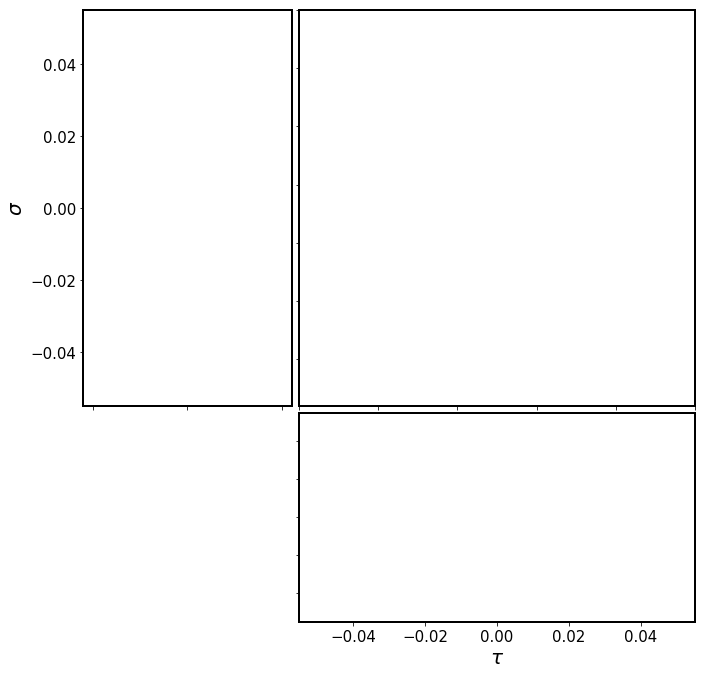

In [26]:
-